In [83]:
# 라이브러리 불러오기
import wave
import array
import soundfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa

### **wave test**

In [75]:
# wav 파일 읽기
f = wave.open("freesound_ring.wav")

# wav 파일 정보 추출 : .getparams
# output : _wave_params(nchannels=2, sampwidth=3, framerate=48000, nframes=371515, comptype='NONE', compname='not compressed')
n_channels, samplewidth, framerate, n_frames = f.getparams()[:4]
bit_depth = samplewidth * 8


# 정보 확인
print("n_channels:", n_channels) # 녹음 채널 수  # stereo 2, mobo 1
print("n_frames:", n_frames)     # 녹음 프레임 수
print("n_frames:", f.getnframes()) # 녹음 프레임 수
print("framerate:", framerate)   # 샘플링 레이트
print("bitdepth:", bit_depth)    # 프레임 당 사용 비트 수



n_channels: 2
n_frames: 371515
n_frames: 371515
framerate: 48000
bitdepth: 24


In [76]:
# 모든 프레임 읽기 > readframes : 최대 n개의 오디오 프레임을 읽어들여 bytes 객체로 반환
audio_bytes = f.readframes(n_frames) # wav 파일의 모든 진폭값을 취득 가능

# 프레임 정보 확인
print("type of readframes result:", type(audio_bytes))  # readframes의 결과 타입 출력
print("length of readframes result:", len(audio_bytes))  # readframes의 결과 길이 출력
print("part of bytes:", audio_bytes[:10])  # 읽어온 데이터의 일부 출력

type of readframes result: <class 'bytes'>
length of readframes result: 2229090
part of bytes: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff'


In [77]:
sampwidth = int(bit_depth/8) # 24 bit > 3 byte
audio_array = [] # 프레인 parsing


# 오디오 바이트를 bitdepth만큼 처리
for i in range(0, len(audio_bytes), sampwidth):
    # 3바이트를 결합하여 24비트 정수 생성 (little-endian 형식)
    sample = int.from_bytes(audio_bytes[i:i+3], byteorder='little', signed=True)
    # 생성된 샘플을 리스트에 추가
    audio_array.append(sample)

print(len(audio_array))
print(audio_array[:15]) # byte 형의 프레임 데이터를 list 자료형으로 변환


743030
[0, 0, 0, -1, 1, -2, 1, -3, 2, -4, 2, -5, 3, -7, 3]


In [78]:
# [0,1]으로 scaling
scaled_array = [value / 2**(bit_depth - 1) for value in audio_array]

# 확인
print(len(scaled_array))
print(scaled_array[:15])

743030
[0.0, 0.0, 0.0, -1.1920928955078125e-07, 1.1920928955078125e-07, -2.384185791015625e-07, 1.1920928955078125e-07, -3.5762786865234375e-07, 2.384185791015625e-07, -4.76837158203125e-07, 2.384185791015625e-07, -5.960464477539062e-07, 3.5762786865234375e-07, -8.344650268554688e-07, 3.5762786865234375e-07]


In [79]:
# Channel 분리
multichannel_array = [scaled_array[i::n_channels] for i in range(n_channels)]
# 분리된 Channel 수 출력
print(len(multichannel_array))
# 채널 1 의 프레임 수 확인
print(len(multichannel_array[0]))

2
371515


In [80]:
# 오디오 확인
# Audio(multichannel_array[0], rate=framerate) # 채널 1
Audio(multichannel_array[1], rate=framerate) # 채널 2

In [81]:
# 하나의 채널로 병합 : 평균 방식
avg_array = [(ch1 + ch2)/2 for ch1, ch2 in zip(*multichannel_array)]
# 재생
Audio(avg_array, rate=framerate)

In [87]:
# 저장 Option 설정하기 > 기존의 파일보다 크기 축소
n_channels = 1         # Mono
sampwidth = 2          # 16 bitdepth
framerate = 44100      # 샘플레이트 (예시로 44100Hz 사용)
avg_array = [0.5, -0.5, 0.25, -0.25]  # 예시 데이터
n_frames = len(avg_array)

# 쓰기 위한 stream 불러오기
tf = wave.open('train_wave.wav', 'wb')

# 정해진 옵션을 세팅 : .setparams
tf.setparams((n_channels, sampwidth, framerate, n_frames, 'NONE', 'not compressed'))

# Normalize : 최대 magnitude value 확인
max_value = max(max(avg_array), -min(avg_array))

# 16-bit 오디오의 최대 값에 맞추기 위해 scaling factor를 계산
scale_factor = 32767.0 / max_value  # 32767.0 : 16비트 오디오 데이터의 최대값
mixed_array_normalized = [int(round(sample * scale_factor)) for sample in avg_array]  # 각 샘플을 16비트 범위로 정규화

# 정규화된 샘플을 16비트(short) 정수 배열로 변환
mixed_byte_array_normalized = array.array('h', mixed_array_normalized)  # 'h' : 16비트(2바이트) 정수형(short integer) 의미

# 파일 쓰기
tf.writeframes(mixed_byte_array_normalized.tobytes())
tf.close()

print("파일 쓰기 완료")

파일 쓰기 완료


### **Librosa test**

In [88]:
# sample rate 확인하기
n_channels , _, sr,_ = f.getparams()[:4]
# print(n_channels) # 2 : stereo
lrs_array, sample_rate = librosa.load("freesound_ring.wav", sr = sr, mono=False)

# shape 확인 : wave 결과와 동일
print("shape is ",lrs_array.shape)
print("** part of contents(librosa) **")
print(lrs_array[0, :5])
print(lrs_array[1, :5])
print()
print("** part of contents(wave) **")
print(multichannel_array[0][:5])
print(multichannel_array[1][:5])

# # 파일 재생
# Audio(lrs_array, rate = sample_rate)

# 오디오 쓰고 저장 by soundfile
soundfile.write("testlibrosa.wav", lrs_array.T, samplerate=sr) # 기존의 shape을 Transpose

# # 저장된 파일 재생
# Audio("test_librosa.wav")

shape is  (2, 371515)
** part of contents(librosa) **
[0.0000000e+00 0.0000000e+00 1.1920929e-07 1.1920929e-07 2.3841858e-07]
[ 0.0000000e+00 -1.1920929e-07 -2.3841858e-07 -3.5762787e-07
 -4.7683716e-07]

** part of contents(wave) **
[0.0, 0.0, 1.1920928955078125e-07, 1.1920928955078125e-07, 2.384185791015625e-07]
[0.0, -1.1920928955078125e-07, -2.384185791015625e-07, -3.5762786865234375e-07, -4.76837158203125e-07]


In [89]:
## signoid fuction 생성 함수(:사인파 함수)

## option 지정
# frequency : Hz
# amplitude : Range [0.0, 1.0]
# duration in seconds
# sample_rate in Hertz
# phase in radians

def generate_sinewave(
    frequency: int = 10,   
    amplitude: int = 1,   
    duration: int = 1,        
    sample_rate: int = 44100, 
    phase: int = 0           
):

    # 프레임 간격 결정 : 0부터 duration까지의 시간을 생성 (총 샘플 수: sample_rate * duration)
    t = np.linspace(0, duration, int(sample_rate * duration))

    # 기본 함수 생성
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t + phase)

    if t is None:
        t = np.array(len(sine_wave)) / sample_rate
    
    return t, sine_wave

In [90]:
def generate_waveform(waveform, sample_rate, t=None):
    # x축 정의 : Time (sec)
    if t is None:
        t = np.arange(len(waveform)) / sample_rate
    # 파형 시각화
    plt.figure(figsize=(7,2))
    plt.plot(t, waveform)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.tight_layout()
    plt.show()

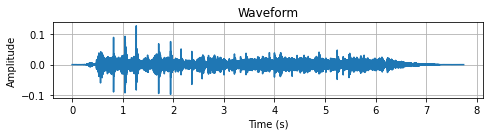

In [91]:
# 파일 불러오기
audio, sample_rate = librosa.load('testlibrosa.wav', sr=16000)

# X축 정의
times = np.arange(len(audio)) / sr

# 전체 파형 그리기
generate_waveform(audio, sample_rate)

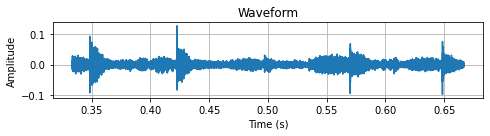

In [92]:
## 특정 구간 시각화
ss = 1 # 시작 시간(초)
es = 2 # 끝 시간(초)

# 시작 및 끝 정의 (프레임 단위)
start_frame = int(ss * sample_rate)
end_frame = int(es * sample_rate)

# Segment 분리
time_segment  = times[start_frame:end_frame]
audio_segment = audio[start_frame:end_frame]

generate_waveform(audio_segment, sample_rate, t=time_segment)

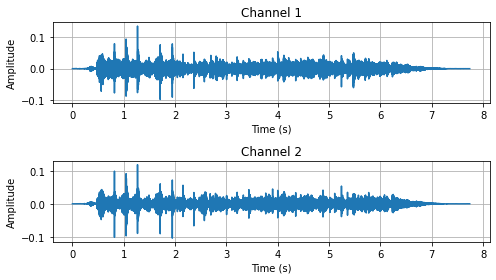

In [93]:
## 다채널 시각화

# 파일 불러오기 : stereo 
audio, sample_rate = librosa.load('testlibrosa.wav', sr=16000, mono=False)

# # 파일 Shape 확인
# print(audio.shape)

# 시각화 채널 수 결정 : 2
num_channels = audio.shape[0]

# X축 정의
times = np.arange(audio.shape[1]) / sample_rate

# 시각화
plt.figure(figsize=(7, 2 * num_channels))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(times, audio[i, :])
    plt.title(f"Channel {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
plt.tight_layout()
plt.show()

#### **Audio control**
1. volume control : 오디오 배열의 값에 특정 계수를 곱하는 방식
2. reversed control : 배열을 인덱스를 뒤집어 재생 방향을 역재생
3. speed control : Interpolation 기법으로 오디오의 재생 속도 조절

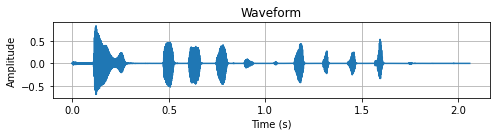

In [94]:
## 원본
# 파일 불러오기
audio, sample_rate = librosa.load('freesound_laugh.wav', sr=16000, mono=True)

# 시각화
generate_waveform(audio, sample_rate)

# 재생
Audio(audio, rate=sample_rate)


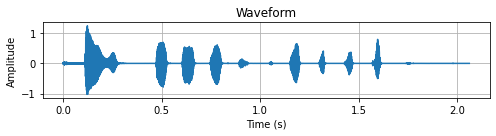

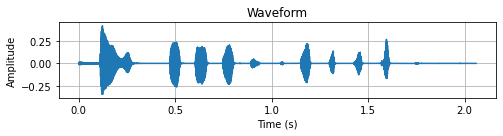

--- >> Play Amplified Audio


In [98]:
## 1. volume control
# Factor 조절
factor1 = 1.5
factor2 = 0.5

# 음량 조절 적용 : 전체 계수 조정
amplified_audio = audio * factor1
reduced_audio = audio * factor2

# 시각화
generate_waveform(amplified_audio, sample_rate)
generate_waveform(reduced_audio, sample_rate)

# 재생
print("--- >> Play Amplified Audio")
Audio(amplified_audio, rate=sample_rate)
# print("--- >> Play Reduced Audio")
# Audio(reduced_audio, rate=sample_rate)

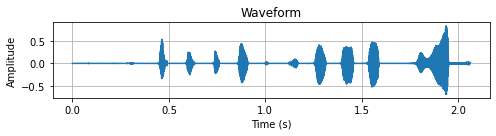

In [99]:
## 2. reversed control
reversed_audio = audio[::-1]

# 시각화
generate_waveform(reversed_audio, sample_rate)

# 재생

Audio(reversed_audio, rate=sample_rate)

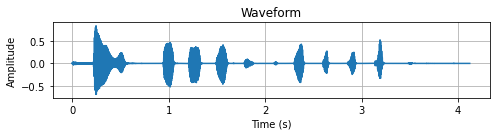

In [100]:
## 3. speed control

factor = 2.0 # 총 길이를 2배로 늘이기 >> 느리게
# factor = 0.5 # 총 재생 길이를 0.5배로 축소하기 >> 빠르게

# 수정될 길이 정의
stretched_len = int(len(audio) * factor)


x_old = np.linspace(0, 1, len(audio)) # 기존 오디오의 선형 공간
x_new = np.linspace(0, 1, stretched_len) # 조정된 오디오의 선형 공간


# interpolate 수행 
# : audio와 x_old(기존 선형공간)에 대하여 x_new(새로운 선형공간)에 해당하는 새로운 오디오 생성
stretched_audio = np.interp(x_new, x_old, audio)

# 시각화
generate_waveform(stretched_audio, sample_rate)

# 재생
Audio(stretched_audio, rate=sample_rate)

#### **Additional Audio Control Method**
1. cut off : 인덱싱 사용 
2. paste : 인덱싱 사용
3. fade in & fade out : linsapce 사용 <오디오의 양 끝 및 연결 구간을 자연스럽게 수정>

In [114]:
# 자르는 함수 정의
def cut(signal, start_sample, end_sample):
    return signal[start_sample:end_sample]

# 붙이는 함수 정의
def paste(signals):
    return np.concatenate(signals, axis=0)

def fade_in(signal, fade_samples):
    fade_curve = np.linspace(0, 1, fade_samples)
    output = signal.copy()
    output[:fade_samples] *= fade_curve
    return output

def fade_out(signal, fade_samples):
    fade_curve = np.linspace(1, 0, fade_samples)
    output = signal.copy()
    output[-fade_samples:] *= fade_curve
    return output

In [108]:
## Cutting

# 1. 사용자 정의 기준 cut off
start_frame = 0
end_frame   = 16000
# 자르기
audio1 = cut(audio, start_frame, end_frame)
# shape 출력
print(audio1.shape)


# 2. sample_rate를 사용하여 cut off
start_frame = int(0.5 * sample_rate)
end_frame   = int(1.5 * sample_rate)
# 자르기
audio2 = cut(audio, start_frame, end_frame)
# shape 확인
print(audio2.shape)
print()

# 잘린 오디오 재생
print("-- Audio version 1 : 사용자 정의 기준 cut off")
display(Audio(audio1, rate=sample_rate))
print("-- Audio version 2 : sample_rate를 사용하여 cut off")
display(Audio(audio2, rate=sample_rate))

(16000,)
(16000,)

-- Audio version 1 : 사용자 정의 기준 cut off


-- Audio version 2 : sample_rate를 사용하여 cut off


In [113]:
## Paste

# 오디오 불러오기
audio1, sample_rate = librosa.load('freesound_laugh.wav', sr=16000, mono=True)
audio2, sample_rate = librosa.load('testlibrosa.wav', sr=16000, mono=True)

# 오디오 선택 : list로 concat
audios = [audio1, audio2]

# 붙이기
cat_audio = paste(audios)

# shape 출력
print(cat_audio.shape)
print()

# 확인
print()
print("-- Audio : 오디오 결합")
display(Audio(cat_audio, rate=sample_rate))

(156798,)


-- Audio : 오디오 결합


In [116]:
## Fade-In and Fade-Out
audio_in = fade_in(audio1, 16000) # 시작 구간 페이드 인
audio_out = fade_out(audio1, 16000) # 시작 구간 페이드 아웃

# 확인
print("--> Audio version Fade-In")
display(Audio(audio_in, rate=sample_rate))
print("--> Audio version Fade-Out")
display(Audio(audio_out, rate=sample_rate))

--> Audio version Fade-In


--> Audio version Fade-Out


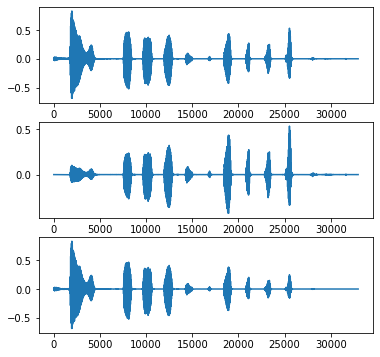

In [118]:
f, ax = plt.subplots(3,1,figsize=(6,6))
ax[0].plot(audio1)
ax[1].plot(audio_in)
ax[2].plot(audio_out)
plt.show()

#### **filter 적용해보기**
: 시간 영역에서 이동 평균 필터를 생성

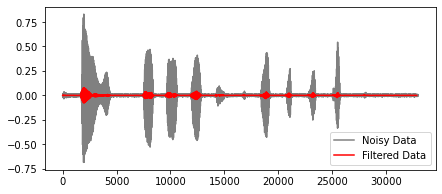

In [121]:
# 파일 불러오기
audio, ar = librosa.load("freesound_laugh.wav", sr = 16000, mono = True)

# 잡음 생성 및 추가
noise =  0.005 * np.random.randn(len(audio))
noisyaudio = audio + noise

# 필터 생성 및 적용
window_size = 100
average_filter = np.ones(window_size) / window_size
filtered_data = np.convolve(noisyaudio, average_filter, mode = 'valid') # valid : array들이 overlapping되는 부분만 계산

# 시각화
plt.figure(figsize=(7, 3))
plt.plot(noisyaudio, label='Noisy Data', color= 'grey')
plt.plot(filtered_data, label='Filtered Data', color='red')
plt.legend()
plt.show()